In [1]:
import numpy as np
import cv2
import imutils
from imutils import contours
from mrcnn import visualize
import matplotlib.pyplot as plt

%matplotlib inline

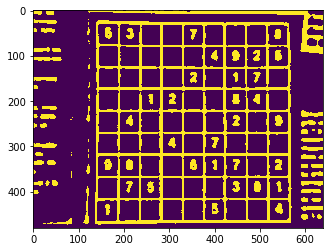

In [31]:
im = cv2.imread("v1_training/image51.jpg")
TARGET_SIZE = (480,480) #reimagesize
im_resized = im
gray = cv2.cvtColor(im_resized, cv2.COLOR_BGR2GRAY) #to grayscale
dst = cv2.fastNlMeansDenoising(gray)
mask=cv2.adaptiveThreshold(dst,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,57,5)
plt.imshow(mask)

[[[141  24]]

 [[137 471]]

 [[568 468]]

 [[564  28]]]


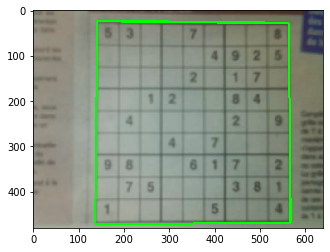

In [32]:
cnts_bl = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts_bl = imutils.grab_contours(cnts_bl)

output = im_resized.copy()
findcon = []


for i in cnts_bl:
    if cv2.contourArea(i) > 10000:
        ii = i
        epsilon = 0.08 * cv2.arcLength(i, True)
        approx = cv2.approxPolyDP(i, epsilon, True)
        cv2.drawContours(output, [approx], -1, (0, 255, 0), 4)
#         cv2.drawContours(output, [i], -1, (0, 0, 255), 1)
#         x, y, w, h = cv2.boundingRect(i)
#         print(x,' ',y,' ',w,' ',h)
        findcon.append([x,y])  
print(approx)
plt.imshow(output)


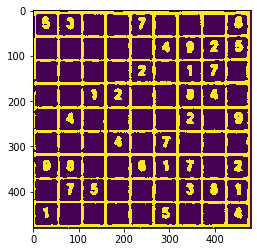

In [33]:
#Conner of sudoku
approx[0][0]
# tl = [x,y]
# tr = [x,y+h]
# br = [x+w,y+h]
# bl = [x+w,y]
tl = approx[0][0]
tr = approx[1][0]
br = approx[2][0]
bl = approx[3][0]

#Make a Warp 
width,height = TARGET_SIZE[0],TARGET_SIZE[1]
pts1 = np.float32([tl,bl,tr,br])
pts2 = np.float32([[0,0],[width,0],[0,height],[width,height]])
M = cv2.getPerspectiveTransform(pts1,pts2)
warp = cv2.warpPerspective(output,M,(width,height))
gray_warp = cv2.cvtColor(warp, cv2.COLOR_BGR2GRAY)
mask_warp = cv2.adaptiveThreshold(gray_warp,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,57,5)
plt.imshow(mask_warp)

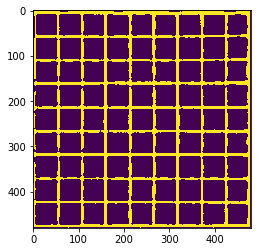

In [34]:
cnts = cv2.findContours(mask_warp, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    area = cv2.contourArea(c)
    if area < 1000:
        cv2.drawContours(mask_warp, [c], -1, (0,0,255), -1)
plt.imshow(mask_warp)

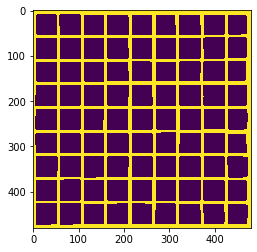

In [35]:
# Fix horizontal and vertical lines
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,3))
thresh = cv2.morphologyEx(mask_warp, cv2.MORPH_CLOSE, vertical_kernel, iterations=9)
plt.imshow(thresh)
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,1))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, horizontal_kernel, iterations=6)
plt.imshow(thresh)

In [36]:
invert = 255 - thresh
cnts = cv2.findContours(invert, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
(cnts, _) = contours.sort_contours(cnts, method="top-to-bottom")

sudoku_rows = []
row = []
for (i, c) in enumerate(cnts, 1):
    area = cv2.contourArea(c)
    if area < 50000:
        row.append(c)
        if i % 9 == 0:  
            (cnts, _) = contours.sort_contours(row, method="left-to-right")
            sudoku_rows.append(cnts)
            row = []

In [37]:
# Iterate through each box
count = 0
for row in sudoku_rows:
    for c in row:
        count+=1
        mask = np.zeros(warp.shape, dtype=np.uint8)
        cv2.drawContours(mask, [c], -1, (255,255,255), -1)
        result = cv2.bitwise_and(warp, mask)
        result[mask==0] = 255
        cv2.imshow('res',result)
        cv2.waitKey(175)
cv2.destroyAllWindows()
print(count)

81
